
<a id='introduction-to-types'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Introduction to Types and Generic Programming

## Contents

- [Introduction to Types and Generic Programming](#Introduction-to-Types-and-Generic-Programming)  
  - [Overview](#Overview)  
  - [Finding and Interpreting Types](#Finding-and-Interpreting-Types)  
  - [The Type Hierarchy](#The-Type-Hierarchy)  
  - [Deducing and Declaring Types](#Deducing-and-Declaring-Types)  
  - [Creating New Types](#Creating-New-Types)  
  - [Introduction to Multiple Dispatch](#Introduction-to-Multiple-Dispatch)  
  - [Exercises](#Exercises)  

## Overview

In Julia, arrays and tuples are the most important data type for working with numerical data

In this lecture we give more details on

- declaring types  
- abstract types  
- motivation for generic programming  
- multiple dispatch  
- building user-defined types  

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.3.0")

In [2]:
using LinearAlgebra, Statistics

## Finding and Interpreting Types

### Finding The Type

As we have seen in the previous lectures, in Julia all values have a type, which can be queried using the `typeof` function

In [3]:
@show typeof(1)
@show typeof(1.0);

typeof(1) = Int64
typeof(1.0) = 

Float64


The hard-coded values `1` and `1.0` are called literals in a programming
language, and the compiler deduces their types (`Int64` and `Float64` respectively in the example above)

You can also query the type of a value

In [4]:
x = 1
typeof(x)

Int64

The name `x` binds to the value `1`, created as a literal

### Parametric Types

(See [parametric types documentation](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1))

The next two types use curly bracket notation to express the fact that they are *parametric*

In [5]:
@show typeof(1.0 + 1im)
@show typeof(ones(2, 2));

typeof(1.0 + 1im) = Complex{Float64}
typeof(ones(2, 2)) = Array{Float64,2}


We will learn more details about [generic programming](https://lectures.quantecon.org/more_julia/generic_programming.html) later, but the key is to interpret the curly brackets as swappable parameters for a given type

For example, `Array{Float64, 2}` can be read as

1. `Array` is a parametric type representing a dense array, where the first parameter is the type stored, and the second is the number of dimensions  
1. `Float64` is a concrete type declaring that the data stored will be a particular size of floating point  
1. `2` is the number of dimensions of that array  


A concrete type is one where values can be created by the compiler (equivalently, one which can be the result of `typeof(x)` for some object `x`)

Values of a **parametric type** cannot be concretely constructed unless all of the parameters are given (themselves with concrete types)

In the case of `Complex{Float64}`

1. `Complex` is an abstract complex number type  
1. `Float64` is a concrete type declaring what the type of the real and imaginary parts of the value should store  


Another type to consider is the `Tuple` and `NamedTuple`

In [6]:
x = (1, 2.0, "test")
@show typeof(x)

typeof(x) = Tuple{Int64,Float64,String}


Tuple{Int64,Float64,String}

In this case, `Tuple` is the parametric type, and the three parameters are a list of the types of each value

For a named tuple

In [7]:
x = (a = 1, b = 2.0, c = "test")
@show typeof(x)

typeof(x) = NamedTuple{(:a, :b, :c),Tuple{Int64,Float64,String}}


NamedTuple{(:a, :b, :c),Tuple{Int64,Float64,String}}

The parametric `NamedTuple` type contains two parameters: first a list of names for each field of the tuple, and second the underlying `Tuple` type to store the values

Anytime a value is prefixed by a colon, as in the `:a` above, the type is `Symbol` – a special kind of string used by the compiler

In [8]:
typeof(:a)

Symbol

**Remark:** Note that, by convention, type names use CamelCase –  `Array`, `AbstractArray`, etc.

### Variables, Types, and Values

Since variables and functions are lower case by convention, this can be used to easily identify types when reading code and output

After assigning a variable name to a value, we can query the type of the
value via the name

In [9]:
x = 42
@show typeof(x);

typeof(x) = Int64


Thus, `x` is just a symbol bound to a value of type `Int64`

We can *rebind* the symbol `x` to any other value, of the same type or otherwise

In [10]:
x = 42.0

42.0

Now `x` “points to” another value, of type `Float64`

In [11]:
typeof(x)

Float64

However, beyond a few notable exceptions (e.g. `nothing` used for [error handling](https://lectures.quantecon.org/fundamental_types.html#error-handling)),
changing types is usually a symptom of poorly organized code, and makes
[type inference](#type-inference) more difficult for the compiler

## The Type Hierarchy

Let’s discuss how types are organized

### Abstract vs Concrete Types

(See [abstract types documentation](https://docs.julialang.org/en/v1/manual/types/#Abstract-Types-1))

Up to this point, most of the types we have worked with (e.g., `Float64, Int64`) are examples of **concrete types**

Concrete types are types that we can *instantiate* – i.e., pair with data in memory

We will now examine **abstract types** that cannot be instantiated (e.g., `Real`, `AbstractFloat`)

For example, while you will never have a `Real` number directly in memory, the abstract types
help us organize and work with related concrete types

### Subtypes and Supertypes

How exactly do abstract types organize or relate different concrete types?

In the Julia language specification, the types form a hierarchy

You can check if a type is a subtype of another with the `<:` operator

In [12]:
@show Float64 <: Real
@show Int64 <: Real
@show Complex{Float64} <: Real
@show Array <: Real;

Float64 <: Real = true
Int64 <: Real = true
Complex{Float64} <: Real = false
Array <: Real = false


In the above, both `Float64` and `Int64` are **subtypes** of `Real`, whereas the `Complex` numbers are not

They are, however, all subtypes of `Number`

In [13]:
@show Real <: Number
@show Float64 <: Number
@show Int64 <: Number
@show Complex{Float64} <: Number;

Real <: Number = true
Float64 <: Number = true
Int64 <: Number = true
Complex{Float64} <: Number = true


`Number` in turn is a subtype of `Any`, which is a parent of all types

In [14]:
Number <: Any

true

In particular, the type tree is organized with `Any` at the top and the concrete types at the bottom

We never actually see *instances* of abstract types (i.e., `typeof(x)` never returns an abstract type)

The point of abstract types is to categorize the concrete types, as well as other abstract types that sit below them in the hierarchy

There are some further functions to help you explore the type hierarchy, such as `show_supertypes` which walks up the tree of types to `Any` for a given type

In [15]:
using Base: show_supertypes  # import the function from the `Base` package

show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

And the `subtypes` which gives a list of the available subtypes for any packages or code currently loaded

In [16]:
@show subtypes(Real)
@show subtypes(AbstractFloat);

subtypes(Real) = Any[AbstractFloat, AbstractIrrational, Integer, Rational]
subtypes(AbstractFloat) = Any[BigFloat, Float16, Float32, Float64]



<a id='type-inference'></a>

## Deducing and Declaring Types

We will discuss this in detail in [generic programming](https://lectures.quantecon.org/more_julia/generic_programming.html),
but much of Julia’s performance gains and generality of notation comes from its type system

For example

In [17]:
x1 = [1, 2, 3]
x2 = [1.0, 2.0, 3.0]

@show typeof(x1)
@show typeof(x2)

typeof(x1) = Array{Int64,1}
typeof(x2) = Array{Float64,1}


Array{Float64,1}

These return `Array{Int64,1}` and `Array{Float64,1}` respectively, which the compiler is able to infer from the right hand side of the expressions

Given the information on the type, the compiler can work through the sequence of expressions to infer other types

In [18]:
f(y) = 2y # define some function


x = [1, 2, 3]
z = f(x) # call with an integer array - compiler deduces type

3-element Array{Int64,1}:
 2
 4
 6

### Good Practices for Functions and Variable Types

In order to keep many of the benefits of Julia, you will sometimes want to ensure
the compiler can always deduce a single type from any function or expression

An example of bad practice is to use an array to hold unrelated types

In [19]:
x = [1.0, "test", 1]  # typically poor style

3-element Array{Any,1}:
 1.0    
  "test"
 1      

The type of this array is `Array{Any,1}`, where `Any` means the compiler has determined that any valid Julia type can be added to the array

While occasionally useful, this is to be avoided whenever possible in performance sensitive code

The other place this can come up is in the declaration of functions

As an example, consider a function which returns different types depending on the arguments

In [20]:
function f(x)
    if x > 0
        return 1.0
    else
        return 0  # probably meant `0.0`
    end
end

@show f(1)
@show f(-1);

f(1) = 1.0
f(-1) = 0


The issue here is relatively subtle:  `1.0` is a floating point, while `0` is an integer

Consequently, given the type of `x`, the compiler cannot in general determine what type the function will return

This issue, called **type stability**, is at the heart of most Julia performance considerations

Luckily, trying to ensure that functions return the same types is also generally consistent with simple, clear code

### Manually Declaring Function and Variable Types

(See [type declarations documentation](https://docs.julialang.org/en/v1/manual/types/#Type-Declarations-1))

You will notice that in the lecture notes we have never directly declared any types

This is intentional both for exposition and as a best practice for using packages (as opposed to writing new packages, where declaring these types is very important)

It is also in contrast to some of the sample code you will see in other Julia sources, which you will need to be able to read

To give an example of the declaration of types, the following are equivalent

In [21]:
function f(x, A)
    b = [5.0, 6.0]
    return A * x .+ b
end

val = f([0.1, 2.0], [1.0 2.0; 3.0 4.0])

2-element Array{Float64,1}:
  9.1
 14.3

In [22]:
function f2(x::Vector{Float64}, A::Matrix{Float64})::Vector{Float64}
    # argument and return types
    b::Vector{Float64} = [5.0, 6.0]
    return A * x .+ b
end

val = f2([0.1; 2.0], [1.0 2.0; 3.0 4.0])

2-element Array{Float64,1}:
  9.1
 14.3

While declaring the types may be verbose, would it ever generate faster code?

The answer is almost never

Furthermore, it can lead to confusion and inefficiencies since many things that behave like vectors and matrices are not `Matrix{Float64}` and `Vector{Float64}`

Here, the first line works and the second line fails

In [23]:
@show f([0.1; 2.0], [1 2; 3 4])
@show f([0.1; 2.0], Diagonal([1.0, 2.0]))

# f2([0.1; 2.0], [1 2; 3 4]) # not a `Float64`
# f2([0.1; 2.0], Diagonal([1.0, 2.0])) # not a `Matrix{Float64}`

f([0.1; 2.0], [1 2; 3 4]) = [9.1, 14.3]
f([0.1; 2.0], Diagonal([1.0, 2.0])) = 

[5.1, 10.0]


2-element Array{Float64,1}:
  5.1
 10.0

## Creating New Types

(See [type declarations documentation](https://docs.julialang.org/en/v1/manual/types/#Type-Declarations-1))

Up until now, we have used `NamedTuple` to collect sets of parameters for our models and examples

These are useful for maintaining values for model parameters,
but you will eventually need to be able to use code that creates its own types

### Syntax for Creating Concrete Types

(See [composite types documentation](https://docs.julialang.org/en/v1/manual/types/#Composite-Types-1))

While other sorts of types exist, we almost always use the `struct` keyword, which is for creation of composite data types

- “Composite” refers to the fact that the data types in question can be used as collection of named fields  
- The `struct` terminology is used in a number of programming languages to refer to composite data types  


Let’s start with a trivial example where the `struct` we build has fields named `a, b, c`, are not typed

In [24]:
struct FooNotTyped  # immutable by default, use `mutable struct` otherwise
    a # BAD! not typed
    b
    c
end

And another where the types of the fields are chosen

In [25]:
struct Foo
    a::Float64
    b::Int64
    c::Vector{Float64}
end

In either case, the compiler generates a function to create new values of the data type, called a “constructor”

It has the same name as the data type but uses function call notion

In [26]:
foo_nt = FooNotTyped(2.0, 3, [1.0, 2.0, 3.0])  # new `FooNotTyped`
foo = Foo(2.0, 3, [1.0, 2.0, 3.0]) # creates a new `Foo`

@show typeof(foo)
@show foo.a       # get the value for a field
@show foo.b
@show foo.c;

# foo.a = 2.0     # fails since it is immutable

typeof(foo) = Foo
foo.a = 2.0
foo.b = 3
foo.c = [1.0, 2.0, 3.0]


You will notice two differences above for the creation of a `struct` compared to our use of `NamedTuple`

- Types are declared for the fields, rather than inferred by the compiler  
- The construction of a new instance has no named parameters to prevent accidental misuse if the wrong order is chosen  

### Issues with Type Declarations

Was it necessary to manually declare the types `a::Float64` in the above struct?

The answer, in practice, is usually yes

Without a declaration of the type, the compiler is unable to generate efficient code, and the use of a `struct` declared without types could drop performance by orders of magnitude

Moreover, it is very easy to use the wrong type, or unnecessarily constrain the types

The first example, which is usually just as low-performance as no declaration of types at all, is to accidentally declare it with an abstract type

In [27]:
struct Foo2
    a::Float64
    b::Integer  # BAD! Not a concrete type
    c::Vector{Real}  # BAD! Not a concrete type
end

The second issue is that by choosing a type (as in the `Foo` above), you may
be unnecessarily constraining what is allowed

In [28]:
f(x) = x.a + x.b + sum(x.c) # use the type
a = 2.0
b = 3
c = [1.0, 2.0, 3.0]
foo = Foo(a, b, c)
@show f(foo)   # call with the foo, no problem

# some other typed for the values
a = 2   # not a floating point but `f()` would work
b = 3
c = [1.0, 2.0, 3.0]'   # transpose is not a `Vector` but `f()` would work
# foo = Foo(a, b, c)   # fails to compile

# works with `NotTyped` version, but low performance
foo_nt = FooNotTyped(a, b, c)
@show f(foo_nt);

f(foo) = 11.0
f(foo_nt) = 11.0


### Declaring Parametric Types (Advanced)

(See [type parametric types documentation](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types-1))

Motivated by the above, we can create a type which can adapt to holding fields of different types

In [29]:
struct Foo3{T1, T2, T3}
    a::T1   # could be any type
    b::T2
    c::T3
end

# works fine
a = 2
b = 3
c = [1.0, 2.0, 3.0]'    # transpose is not a `Vector` but `f()` would work
foo = Foo3(a, b, c)
@show typeof(foo)
f(foo)

typeof(foo) = Foo3{Int64,Int64,Adjoint{Float64,Array{Float64,1}}}


11.0

Of course, this is probably too flexible, and the `f` function might not work on an arbitrary set of `a, b, c`

You could constrain the types based on the abstract parent type using the `<:` operator

In [30]:
struct Foo4{T1 <: Real, T2 <: Real, T3 <: AbstractVecOrMat{<:Real}}
    a::T1
    b::T2
    c::T3  # should check dimensions as well
end
foo = Foo4(a, b, c)  # no problem, and high performance
@show typeof(foo)
f(foo)

typeof(foo) = Foo4{Int64,Int64,Adjoint{Float64,Array{Float64,1}}}


11.0

This ensures that

- `a` and `b` are a subtype of `Real`, and `+` in the definition of `f` works  
- `c` is a one dimensional abstract array of `Real` values  


The code works, and is equivalent in performance to a `NamedTuple`, but is more verbose and error prone

### Keyword Argument Constructors (Advanced)

There is no way to avoid learning parametric types to achieve high performance code

However, the other issue where constructor arguments are error-prone, can be remedied with the `Parameters.jl` library

In [31]:
using Parameters

@with_kw  struct Foo5
    a::Float64 = 2.0     # adds default value
    b::Int64
    c::Vector{Float64}
end

foo = Foo5(a = 0.1, b = 2, c = [1.0, 2.0, 3.0])
foo2 = Foo5(c = [1.0, 2.0, 3.0], b = 2)  # rearrange order, uses default values

@show foo
@show foo2

function f(x)
    @unpack a, b, c = x     # can use `@unpack` on any struct
    return a + b + sum(c)
end

f(foo)

foo = Foo5
  a: Float64 0.1
  b: Int64 2
  c: Array{Float64}((3,)) [1.0, 2.0, 3.0]

foo2 = Foo5
  a: Float64 2.0
  b: Int64 2
  c: Array{Float64}((3,)) [1.0, 2.0, 3.0]



8.1


<a id='generic-tips-tricks'></a>

### Tips and Tricks for Writing Generic Functions

As discussed in the previous sections, there is major advantage to never declaring a type unless it is absolutely necessary

The main place where it is necessary is designing code around [multiple dispatch](#intro-multiple-dispatch)

If you are careful to write code that doesn’t unnecessarily assume types,
you will both achieve higher performance and allow seamless use of a
number of powerful libraries such as
[auto-differentiation](https://github.com/JuliaDiff/ForwardDiff.jl),
[static arrays](https://github.com/JuliaArrays/StaticArrays.jl),
[GPUs](https://github.com/JuliaGPU/CuArrays.jl),
[interval arithmetic and root finding](https://github.com/JuliaIntervals/IntervalRootFinding.jl),
[arbitrary precision numbers](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/index.html#Arbitrary-Precision-Arithmetic-1),
and many more packages – including ones that have not even been written yet

A few simple programming patterns ensure that this is possible

- Do not declare types when declaring variables or functions unless necessary  

In [32]:
# BAD
x = [5.0, 6.0, 2.1]

function g(x::Array{Float64, 1})   # not generic!
    y = zeros(length(x))   # not generic, hidden float!
    z = Diagonal(ones(length(x)))  # not generic, hidden float!
    q = ones(length(x))
    y .= z * x + q
    return y
end

g(x)

# GOOD
function g2(x)  # or `x::AbstractVector`
    y = similar(x)
    z = I
    q = ones(eltype(x), length(x))  # or `fill(one(x), length(x))`
    y .= z * x + q
    return y
end

g2(x)

3-element Array{Float64,1}:
 6.0
 7.0
 3.1


- Preallocate related vectors with `similar` where possible, and use `eltype` or `typeof`. This is important when using Multiple Dispatch given the different input types the function can call  

In [33]:
function g(x)
    y = similar(x)
    for i in eachindex(x)
        y[i] = x[i]^2      # could broadcast
    end
    return y
end

g([BigInt(1), BigInt(2)])

2-element Array{BigInt,1}:
 1
 4


- Use `typeof` or `eltype` to declare a type  

In [34]:
@show typeof([1.0, 2.0, 3.0])
@show eltype([1.0, 2.0, 3.0]);

typeof([1.0, 2.0, 3.0]) = Array{Float64,1}
eltype([1.0, 2.0, 3.0]) = Float64



- Beware of hidden floating points  

In [35]:
@show typeof(ones(3))
@show typeof(ones(Int64, 3))
@show typeof(zeros(3))
@show typeof(zeros(Int64, 3));

typeof(ones(3)) = Array{Float64,1}
typeof(ones(Int64, 3)) = Array{Int64,1}
typeof(zeros(3)) = Array{Float64,1}
typeof(zeros(Int64, 3)) = Array{Int64,1}



- Use `one` and `zero` to write generic code  

In [36]:
@show typeof(1)
@show typeof(1.0)
@show typeof(BigFloat(1.0))
@show typeof(one(BigFloat))  # gets multiplicative identity, passing in type
@show typeof(zero(BigFloat))

x = BigFloat(2)

@show typeof(one(x))  # can call with a variable for convenience
@show typeof(zero(x));

typeof(1) = Int64
typeof(1.0) = Float64
typeof(BigFloat(1.0)) = BigFloat
typeof(one(BigFloat)) = BigFloat
typeof(zero(BigFloat)) = BigFloat
typeof(one(x)) = BigFloat
typeof(zero(x)) = BigFloat





This last example is a subtle, because of something called [type promotion](https://docs.julialang.org/en/v1/manual/conversion-and-promotion/#Promotion-1)

- Assume reasonable type promotion exists for numeric types  

In [37]:
# ACCEPTABLE
function g(x::AbstractFloat)
    return x + 1.0   # assumes `1.0` can be converted to something compatible with `typeof(x)`
end

x = BigFloat(1.0)

@show typeof(g(x));  # this has "promoted" the `1.0` to a `BigFloat`

typeof(g(x)) = BigFloat


But sometimes assuming promotion is not enough  

In [38]:
# BAD
function g2(x::AbstractFloat)
    if x > 0.0   # can't efficiently call with `x::Integer`
        return x + 1.0   # OK - assumes you can promote `Float64` to `AbstractFloat`
    otherwise
        return 0   # BAD! Returns a `Int64`
    end
end

x = BigFloat(1.0)
x2 = BigFloat(-1.0)

@show typeof(g2(x))
@show typeof(g2(x2))  # type unstable

# GOOD
function g3(x) #
    if x > zero(x)   # any type with an additive identity
        return x + one(x)  # more general but less important of a change
    otherwise
        return zero(x)
    end
end

@show typeof(g3(x))
@show typeof(g3(x2));  # type stable

typeof(g2(x)) = BigFloat
typeof(g2(x2)) = 

Nothing
typeof(g3(x)) = BigFloat
typeof(g3(x2)) = Nothing




These patterns are relatively straightforward, but generic programming can be thought of
as a Leontief production function:  if *any* of the functions you write or call are not
precise enough, then it may break the chain

This is all the more reason to exploit carefully designed packages rather than “do-it-yourself”

### A Digression on Style and Naming

The previous section helps to establish some of the reasoning behind the style
choices in these lectures: “be aware of types, but avoid declaring them”

The purpose of this is threefold:

- Provide easy to read code with minimal “syntactic noise” and a clear correspondence to the math  
- Ensure that code is sufficiently generic to exploit other packages and types  
- Avoid common mistakes and unnecessary performance degradations  


This is just one of many decisions and patterns to ensure that your code is consistent and clear

The best resource is to carefully read other peoples code, but a few sources to review are

- [Julia Style Guide](https://docs.julialang.org/en/v1/manual/style-guide/)  
- [Julia Praxis Naming Guides](https://github.com/JuliaPraxis/Naming/tree/master/guides)  
- [QuantEcon Style Guide](https://github.com/QuantEcon/lecture-source-jl/blob/master/style.md) used in these lectures  


Now why would we emphasize naming and style as a crucial part of the lectures?

Because it is an essential tool for creating research that is
**reproducible** and [**correct**](https://en.wikipedia.org/wiki/Correctness_%28computer_science%29)

Some helpful ways to think about this are

- **Clearly written code is easier to review for errors**: The first-order
  concern of any code is that it correctly implements the whiteboard math  
- **Code is read many more times than it is written**: Saving a few keystrokes
  in typing a variable name is never worth it, nor is a divergence from the
  mathematical notation where a single symbol for a variable name would map better to the model  
- **Write code to be read in the future, not today**: If you are not sure
  anyone else will read the code, then write it for an ignorant future version
  of yourself who may have forgotten everything, and is likely to misuse the code  
- **Maintain the correspondence between the whiteboard math and the code**:
  For example, if you change notation in your model, then immediately update
  all variables in the code to reflect it  

#### Commenting Code

One common mistake people make when trying to apply these goals is to add in a large number of comments

Over the years, developers have found that excess comments in code (and *especially* big comment headers used before every function declaration) can make code *harder* to read

The issue is one of syntactic noise: if most of the comments are redundant given clear variable and function names, then the comments make it more difficult to mentally parse and read the code

If you examine Julia code in packages and the core language, you will see a great amount of care taken in function and variable names, and comments are only added where helpful

For creating packages that you intend others to use, instead of a comment header, you should use [docstrings](https://docs.julialang.org/en/v1/manual/documentation/index.html#Syntax-Guide-1)


<a id='intro-multiple-dispatch'></a>

## Introduction to Multiple Dispatch

One of the defining features of Julia is **multiple dispatch**, whereby the same function name can do different things depending on the underlying types

Without realizing it, in nearly every function call within packages or the standard library you have used this feature

To see this in action, consider the absolute value function `abs`

In [39]:
@show abs(-1)   # `Int64`
@show abs(-1.0)  # `Float64`
@show abs(0.0 - 1.0im);  # `Complex{Float64}`

abs(-1) = 1
abs(-1.0) = 1.0
abs(0.0 - 1.0im) = 1.0


In all of these cases, the `abs` function has specialized code depending on the type passed in

To do this, a function specifies different **methods** which operate on a particular set of types

Unlike most cases we have seen before, this requires a type annotation

To rewrite the `abs` function

In [40]:
function ourabs(x::Real)
    if x > zero(x)   # note, not 0!
        return x
    else
        return -x
    end
end

function ourabs(x::Complex)
    sqrt(real(x)^2 + imag(x)^2)
end

@show ourabs(-1)   # `Int64`
@show ourabs(-1.0) # `Float64`
@show ourabs(1.0 - 2.0im);  # `Complex{Float64}`

ourabs(-1) = 1
ourabs(-1.0) = 1.0
ourabs(1.0 - 2.0im) = 2.23606797749979


Note that in the above, `x` works for any type of `Real`, including `Int64`, `Float64`, and ones you may not have realized exist

In [41]:
x = -2//3  # `Rational` number, -2/3
@show typeof(x)
@show ourabs(x);

typeof(x) = Rational{Int64}
ourabs(x) = 

2//3


You will also note that we used an abstract type, `Real`, and an incomplete
parametric type, `Complex`, when defining the above functions

Unlike the creation of `struct` fields, there is no penalty in using abstract
types when you define function parameters, as they are used purely to determine which version of a function to use

### Multiple Dispatch in Algorithms (Advanced)

If you want an algorithm to have specialized versions when given different input types, you need to declare the types for the function inputs

As an example where this could come up, assume that we have some grid `x` of values, the results of a function `f` applied at those values, and want to calculate an approximate derivative using forward differences

In that case, given $ x_n, x_{n+1}, f(x_n) $ and $ f(x_{n+1}) $, the forward-difference approximation of the derivative is

$$
f'(x_n) \approx \frac{f(x_{n+1}) - f(x_n)}{x_{n+1} - x_n}
$$

To implement this calculation for a vector of inputs, we notice that there is a specialized implementation if the grid is uniform

The uniform grid can be implemented using an `AbstractRange`, which we can analyze with
`typeof`, `supertype` and `show_supertypes`

In [42]:
x = range(0.0, 1.0, length = 20)
x_2 = 1:1:20   # if integers

@show typeof(x)
@show typeof(x_2)
@show supertype(typeof(x))

typeof(x) = StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
typeof(x_2) = StepRange{Int64,Int64}
supertype(typeof(x)) = AbstractRange{Float64}


AbstractRange{Float64}

To see the entire tree about a particular type, use `show_supertypes`

In [43]:
show_supertypes(typeof(x))  # or typeof(x) |> show_supertypes

StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}} <: AbstractRange{Float64} <: AbstractArray{Float64,1} <: Any

In [44]:
show_supertypes(typeof(x_2))

StepRange{Int64,Int64} <: OrdinalRange{Int64,Int64} <: AbstractRange{Int64} <: AbstractArray{Int64,1} <: Any

The types of the range objects can be very complicated, but are both subtypes of `AbstractRange`

In [45]:
@show typeof(x) <: AbstractRange
@show typeof(x_2) <: AbstractRange;

typeof(x) <: AbstractRange = true
typeof(x_2) <: AbstractRange = true


While you may not know the exact concrete type, any `AbstractRange` has an informal set of operations that are available

In [46]:
@show minimum(x)
@show maximum(x)
@show length(x)
@show step(x);

minimum(x) = 0.0
maximum(x) = 1.0
length(x) = 20
step(x) = 0.05263157894736842


Similarly, there are a number of operations available for any `AbstractVector`, such as `length`

In [47]:
f(x) = x^2
f_x = f.(x)  # calculating at the range values

@show typeof(f_x)
@show supertype(typeof(f_x))
@show supertype(supertype(typeof(f_x)))  # walk up tree again!
@show length(f_x);   # and many more

typeof(f_x) = Array{Float64,1}
supertype(typeof(f_x)) = DenseArray{Float64,1}
supertype(supertype(typeof(f_x))) = AbstractArray{Float64,1}
length(f_x) = 20


In [48]:
show_supertypes(typeof(f_x))

Array{Float64,1} <: DenseArray{Float64,1} <: AbstractArray{Float64,1} <: Any

There are also many functions that can use any `AbstractArray`, such as `diff`

```julia
?diff

search: diff symdiff setdiff symdiff! setdiff! Cptrdiff_t

diff(A::AbstractVector) # finite difference operator of matrix or vector A

# if A is a matrix, specify the dimension over which to operate with the dims keyword argument
diff(A::AbstractMatrix; dims::Integer)
```


Hence, we can call this function for anything of type `AbstractVector`

Finally, we can make a high performance specialization for any `AbstractVector` and `AbstractRange`

In [49]:
derivatives(f::AbstractVector, x::AbstractRange) = diff(f) / step(x)

derivatives (generic function with 1 method)

We can use auto-differentiation to compare the results

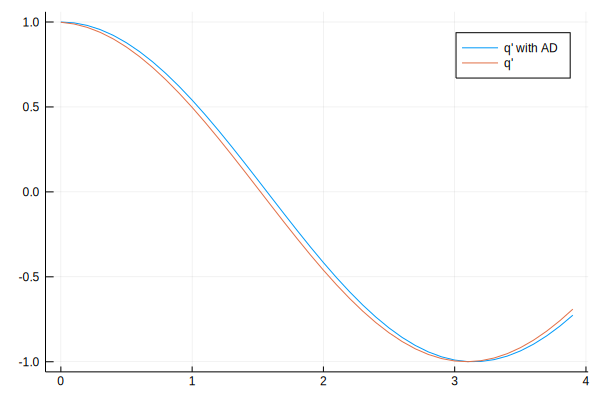

In [50]:
using Plots, ForwardDiff

# operator to get the derivative of this function using AD
D(f) = x -> ForwardDiff.derivative(f, x)

q(x) = sin(x)
x = 0.0:0.1:4.0
q_x = q.(x)
D_q_x = derivatives(q_x, x)

plot(x[1:end-1], D(q).(x[1:end-1]), label = "q' with AD")
plot!(x[1:end-1], D_q_x, label = "q'")

Consider a variation where we pass a function instead of an `AbstractArray`

In [51]:
derivatives(f::Function, x::AbstractRange) = diff(f.(x)) / step(x)  # broadcast function

@show typeof(q) <: Function
d_q = derivatives(q, x)
@show d_q[1];

typeof(q) <: Function = true
d_q[1] = 

0.9983341664682815


Finally, if `x` was an `AbstractArray` and not an `AbstractRange` we can no longer use a uniform step

In [52]:
# broadcasts over the diff
derivatives(f::Function, x::AbstractArray) = diff(f.(x)) ./ diff(x)

d_f = derivatives(f, x)
@show d_f[1];

d_f[1] = 0.10000000000000002


In the final example, we see that it is able to use specialized implementations over both the `f` and the `x` arguments

This is the “multiple” in multiple dispatch

## Exercises

### Exercise 1

Explore the package [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl)

- Describe two abstract types and the hierarchy of three different concrete types  
- Benchmark the calculation of some simple linear algebra with a static array
  compared to the following for a dense array for `N = 3` and `N = 15`  

In [53]:
using BenchmarkTools

N = 3
A = rand(N, N)
x = rand(N)

@btime $A * $x  # the $ in front of variable names is sometimes important
@btime inv($A)

  88.418 ns (1 allocation: 112 bytes)


  748.339 ns (5 allocations: 1.98 KiB)


3×3 Array{Float64,2}:
 -5.86385  12.7963    0.34114 
  1.81073  -6.38571   2.02584 
  2.73721  -2.29578  -0.862613

### Exercise 2

A key step in the calculation of the Kalman Filter is calculation of the Kalman gain, as can be seen with the following example using dense matrices from [the Kalman lecture](https://lectures.quantecon.org/tools_and_techniques/kalman.html)

Using what you learned from Exercise 1, benchmark this using Static Arrays

In [54]:
Σ = [0.4  0.3;
     0.3  0.45]
G = I
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R)

  817.368 ns (10 allocations: 1.94 KiB)


2×2 Array{Float64,2}:
 0.666667     1.11022e-16
 1.11022e-16  0.666667   

How many times faster are static arrays in this example?

### Exercise 3

The [Polynomial.jl](https://github.com/JuliaMath/Polynomials.jl) provides a package for simple univariate Polynomials

In [55]:
using Polynomials

p = Poly([2, -5, 2], :x)  # :x just gives a symbol for display

@show p
p′ = polyder(p)   # gives the derivative of p, another polynomial
@show p(0.1), p′(0.1)  # call like a function
@show roots(p);   # find roots such that p(x) = 0

p = Poly(2 - 5*x + 2*x^2)
(p(0.1), p′(0.1)) = 

(1.52, -4.6)


roots(p) = [0.5, 2.0]


Plot both `p(x)` and `p′(x)` for $ x \in [-2, 2] $

### Exercise 4

Use your solution to Exercise 8(a/b) in [Introductory Examples](https://lectures.quantecon.org/julia_by_example.html) to
create a specialized version of Newton’s method for `Polynomials` using the `polyder` function

The signature of the function should be `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`,
where `p::Poly` ensures that this version of the function will be used anytime a polynomial is passed (i.e. dispatch)

Compare the results of this function to the built-in `roots(p)` function

### Exercise 5 (Advanced)

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximates an integral with

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = \underline{x},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * Exploit the fact that `AbstractRange` has constant step sizes to specialize the algorithm  
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * For this, build a uniform grid with `N` points on `[x̲, x̄]` – call the `f` function at those grid points and use the existing `trapezoidal(f, x)` from the implementation  


With these:
1. Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $
2. From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values
3. Consider trying different functions for $ f(x) $ and compare the solutions for various `N`

When trying different functions, instead of integrating by hand consider using a high-accuracy
library for numerical integration such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/)

In [56]:
using QuadGK

f(x) = x^2
value, accuracy = quadgk(f, 0.0, 1.0)

(0.3333333333333333, 5.551115123125783e-17)

### Exercise 6 (Advanced)

Take a variation of your code in Exercise 5

Use auto-differentiation to calculate the following derivative for the example functions

$$
\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx
$$

Hint: See the following code for the general pattern, and be careful to
follow the [rules for generic programming](#generic-tips-tricks)

In [57]:
using ForwardDiff

function f(a, b; N = 50)
    r = range(a, b, length=N) # one
return mean(r)
end

Df(x) = ForwardDiff.derivative(y -> f(0.0, y), x)

@show f(0.0, 3.0)
@show f(0.0, 3.1)

Df(3.0)

f(0.0, 3.0) = 1.5
f(0.0, 3.1) = 1.55


0.5